# Plot correspondences in registration

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import loadmat
from IPython.display import HTML

from otimage import imagerep, io
from otimage.utils import plot_maxproj
from otimage.imagereg import ot_registration, gw_registration

## Load Zimmer data

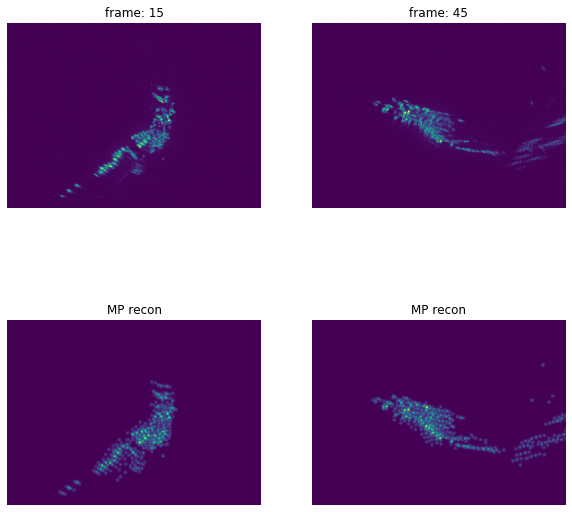

In [3]:
# Frame index
t1 = 15
t2 = 45

# Load two successive frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with io.ZimmerReader(img_path) as reader:
    units = reader.units
    img_1 = reader.get_frame(t1)
    img_2 = reader.get_frame(t2)

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.h5'
with io.MPReader(mp_path) as reader:
    mp_1 = reader.get_frame(t1)
    mp_2 = reader.get_frame(t2)

# Reconstruct images from MPs
rec_1 = imagerep.reconstruct_mp_image(mp_1, units)
rec_2 = imagerep.reconstruct_mp_image(mp_2, units)
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img_1)
plt.title(f'frame: {t1}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img_2)
plt.title(f'frame: {t2}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(rec_1)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(rec_2)
plt.title('MP recon')
plt.axis('off');

## Compute registration for images

In [4]:
degree = 2
n_iter = 50

model, debug = gw_registration(mp_2, mp_1, degree=degree, n_iter=n_iter)

print('beta (est):')
print(model.beta)

beta (est):
[[-4.56309288e+02  3.07099773e+00  6.16292707e+00  8.36375739e+00
  -4.98219832e-03 -1.40575257e-02 -1.74705185e-02 -1.13493345e-02
  -7.13549981e-02  3.42212881e-02]
 [-1.56002866e+02  5.86223091e-01  3.38885852e+00  5.70259966e+00
   1.09399266e-04 -8.50193199e-03 -1.55747872e-02 -5.29664212e-03
  -4.54367507e-02  1.55709460e-02]
 [-2.17397477e+00  1.54464913e-01  4.72784245e-01 -3.46882284e+00
  -8.58015238e-04  1.27043858e-03  8.44510522e-03 -3.60124775e-03
   1.47729343e-02 -1.79047823e-03]]


## Compute pullback with identified MP component

In [5]:
# Transform MP points for second image using mapping
pb_pts = model.predict(mp_2.pts)

# Reconstruct image from transformed points
mp_pb = imagerep.ImageMP(pb_pts, mp_2.wts, mp_2.cov, mp_2.img_limits)
rec_pb = imagerep.reconstruct_mp_image(mp_pb, units)

## Plot pullback and MP components

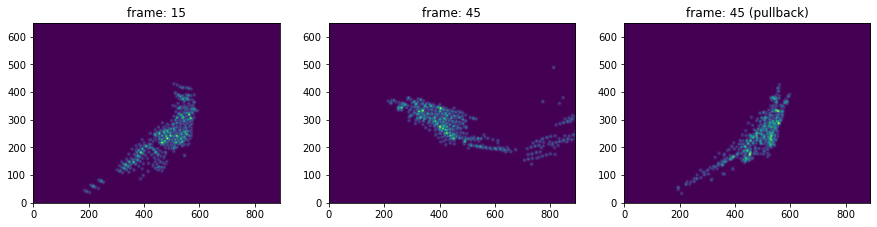

In [6]:
plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(rec_1)
plt.title(f'frame: {t1}')
        
plt.subplot(132)
plot_maxproj(rec_2)
plt.title(f'frame: {t2}')
        
plt.subplot(133)
plot_maxproj(rec_pb)
plt.title(f'frame: {t2} (pullback)');

In [8]:
pts_1_vx = mp_1.pts / units
pts_2_vx = mp_2.pts / units
pts_pb_vx = mp_pb.pts / units

def plot_mp(idx):
    
    #c_pt = mp_2.pts[idx]
    #c_pb = mp_pb.pts[idx]
    
    c_pt = pts_2_vx[idx]
    c_pb = pts_pb_vx[idx]
   
    fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(15, 15))

    plot_maxproj(rec_1, ax_1)
    ax_1.set_title(f'frame: {t1}')
        
    plot_maxproj(rec_2, ax_2)
    ax_2.plot(c_pt[0], c_pt[1], color='red', marker='*')
    ax_2.set_title(f'frame: {t2}')
        
    plot_maxproj(rec_pb, ax_3)
    ax_3.plot(c_pb[0], c_pb[1], color='red', marker='*')
    ax_3.set_title(f'frame: {t2} (pullback)');


ipyw.interact(
    plot_mp, 
    idx=ipyw.IntSlider(
        min=0, max=mp_1.pts.shape[0], step=1, 
        continuous_update=False, description='MP:'
    )
);

interactive(children=(IntSlider(value=0, continuous_update=False, description='MP:', max=500), Output()), _dom…

## Notes

### Correspondence accuracy

(all registrations were run with `n_iter=50`

#### OT registration, quadratic model

- Ran on frames 3 and 4, and correspondence was accurate
- Ran on frames 3 and 10, and correspondence was not accurate
- Example indices where MPs are poorly matched: 5, 7, 8, 15, 17, 19, 25, 28

#### OT registration, cubic model

- Ran on frames 3 and 10, and correspondence was not accurate, but might be better than quadratic model
- Example indices where MPs are poorly matched: 2, 3, 8, 10, 13, 31, 33

#### GW registration, quadratic model

- Ran on frames 3 and 4, and correspondence was accurate
- Ran on frames 3 and 10, and correspondence was accurate
- Ran on frames 15 and 45, and correspondence was accurate (this is crazy -- frames are extremely different)